# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [240]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet
!pip install pandas
!pip install seaborn

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [241]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [242]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [243]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [244]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [245]:
your_name = 'Federico' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [246]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [247]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
425,45,male,24.55310,5,no,9788.86590
607,59,female,23.89155,0,yes,25678.77845
428,21,female,16.98315,1,no,3167.45585
1142,52,female,25.10860,0,no,27117.99378
1121,46,male,38.55170,2,no,8347.16430


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [248]:
num_rows = dataframe.index.size
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [249]:
num_cols = dataframe.columns.size
print(num_cols)

6


**Q: What are the column titles of the input variables?**

In [250]:
input_cols = dataframe.columns[0:-1]
input_cols

Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [251]:
categorical_cols = ['sex', 'smoker']
dataframe.head()[categorical_cols]

,sex,smoker
425,male,no
607,female,yes
428,female,no
1142,female,no
1121,male,no


**Q: What are the column titles of output/target variable(s)?**

In [252]:
output_cols = ['charges']
dataframe.head()[output_cols]

,charges
425,9788.86590
607,25678.77845
428,3167.45585
1142,27117.99378
1121,8347.16430


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [253]:
total = dataframe[output_cols].sum()
average_charge = total / dataframe.index.size
average_charge

charges    13224.164203
dtype: float64

In [254]:
dataframe[output_cols].mean()

charges    13224.164203
dtype: float64

In [255]:
print('Minimum', dataframe[output_cols].min())
print('Maximum', dataframe[output_cols].max())

Minimum charges    1121.8739
dtype: float64
Maximum charges    63770.42801
dtype: float64


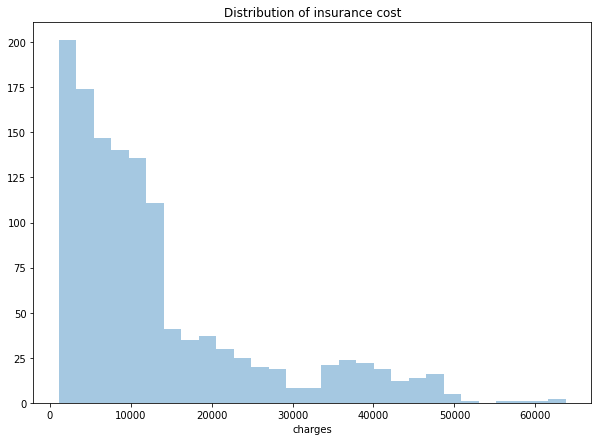

In [256]:
plt.title("Distribution of insurance cost")

sns.distplot(dataframe.charges, kde=False);

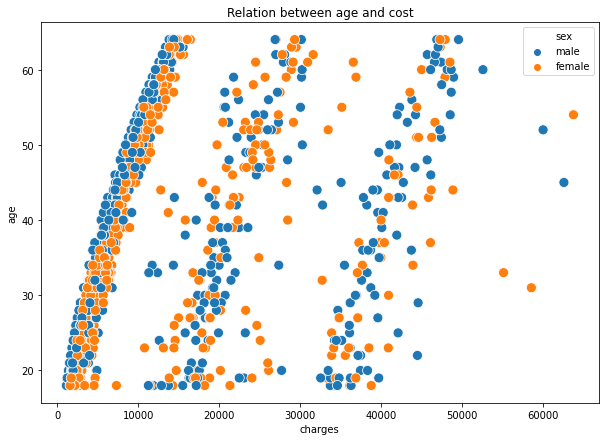

In [257]:
plt.title("Relation between age and cost")
sns.scatterplot(dataframe.charges, # X-axis
                dataframe.age,  # Y-axis
                hue=dataframe.sex,  # Dot color
                s=100)

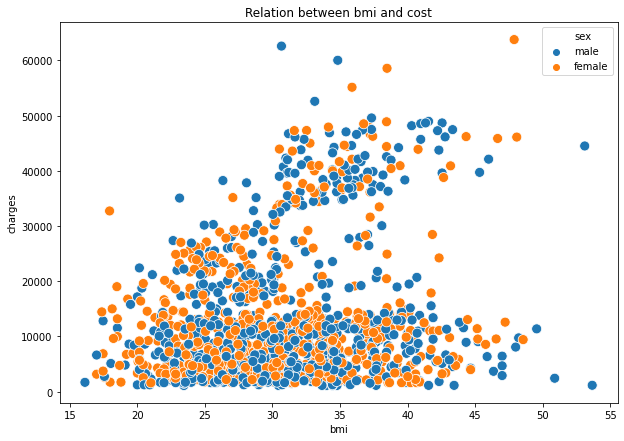

In [258]:
plt.title("Relation between bmi and cost")
sns.scatterplot(dataframe.bmi, # X-axis
                dataframe.charges,  # Y-axis
                hue=dataframe.sex,  # Dot color
                s=100)

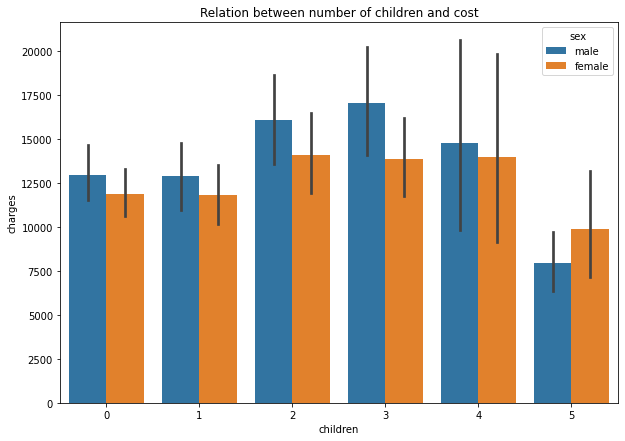

In [259]:
plt.title("Relation between number of children and cost")
sns.barplot(x="children", y="charges", hue="sex", data=dataframe);

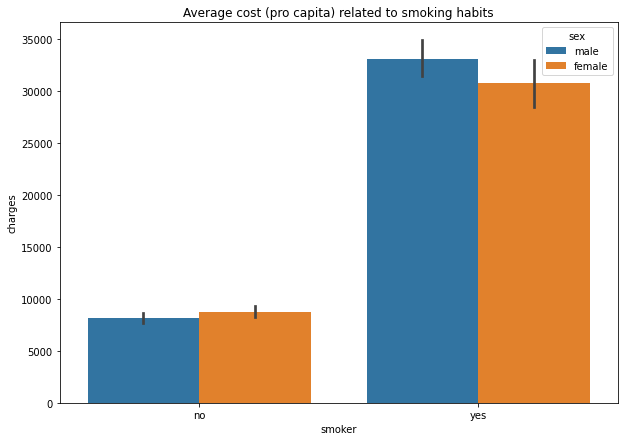

In [260]:
plt.title("Average cost (pro capita) related to smoking habits")
sns.barplot(x="smoker", y="charges", hue="sex", data=dataframe);

In [261]:
smokers = dataframe[dataframe.smoker == 'yes'].index.size
non_smokers = dataframe[dataframe.smoker == 'no'].index.size
print('Smokers:', smokers)
print('Non smokers:', non_smokers)

Smokers: 255
Non smokers: 1016


In [262]:
avg_smokers_charges = dataframe[dataframe.smoker == 'yes'][output_cols].mean()
avg_non_smokers_charges = dataframe[dataframe.smoker == 'no'][output_cols].mean()
print('Average smokers', avg_smokers_charges)
print('Average non smokers', avg_non_smokers_charges)

Average smokers charges    32118.947636
dtype: float64
Average non smokers charges    8481.871116
dtype: float64


In [263]:
avg_smokers_charges / avg_non_smokers_charges

charges    3.786776
dtype: float64

<module 'matplotlib.pyplot' from '/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>

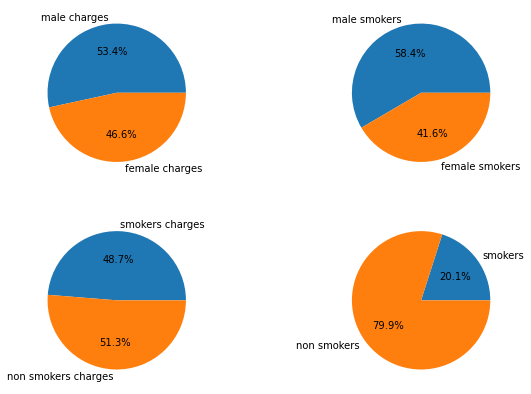

In [264]:
# ignore warnings for aestethic reasons
import warnings
warnings.filterwarnings("ignore")

# Adjust plot size
plt.rcParams["figure.figsize"] = (10, 7)

# Make figure and axes
fig, axs = plt.subplots(2, 2)

sizes = dataframe[dataframe.sex == 'male'][output_cols].sum(), dataframe[dataframe.sex == 'female'][output_cols].sum()
axs[0, 0].pie(sizes, labels=['male charges', 'female charges'], autopct='%1.1f%%')

sizes = dataframe[dataframe.smoker == 'yes'][dataframe.sex == 'male'].index.size, dataframe[dataframe.smoker == 'yes'][dataframe.sex == 'female'].index.size
axs[0, 1].pie(sizes, labels=['male smokers', 'female smokers'], autopct='%1.1f%%')

sizes = dataframe[dataframe.smoker == 'yes'][output_cols].sum(), dataframe[dataframe.smoker == 'no'][output_cols].sum()
axs[1, 0].pie(sizes, labels=['smokers charges', 'non smokers charges'], autopct='%1.1f%%')

sizes = smokers, non_smokers
axs[1, 1].pie(sizes, labels=['smokers', 'non smokers'], autopct='%1.1f%%')

plt

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [266]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [267]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array.shape, inputs_array, targets_array

((1271, 5), array([[45.     ,  1.     , 24.5531 ,  5.     ,  0.     ],
        [59.     ,  0.     , 23.89155,  0.     ,  1.     ],
        [21.     ,  0.     , 16.98315,  1.     ,  0.     ],
        ...,
        [42.     ,  1.     , 28.5931 ,  3.     ,  1.     ],
        [42.     ,  1.     , 25.1086 ,  0.     ,  0.     ],
        [29.     ,  1.     , 37.6629 ,  2.     ,  0.     ]]), array([[ 9788.8659 ],
        [25678.77845],
        [ 3167.45585],
        ...,
        [32787.45859],
        [ 5966.8874 ],
        [ 4058.1161 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [268]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

In [269]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [270]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [271]:
val_percent = 0.1712 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) 

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [272]:
batch_size = 2**8

In [273]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [274]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[19.0000,  0.0000, 20.8060,  0.0000,  0.0000],
        [64.0000,  0.0000, 23.2199,  0.0000,  1.0000],
        [44.0000,  0.0000, 26.0580,  1.0000,  0.0000],
        ...,
        [32.0000,  1.0000, 37.7084,  1.0000,  0.0000],
        [47.0000,  0.0000, 28.1083,  0.0000,  1.0000],
        [55.0000,  0.0000, 37.4710,  0.0000,  0.0000]])
targets: tensor([[ 1731.6770],
        [27037.9141],
        [ 7624.6299],
        [11881.9697],
        [ 2201.0972],
        [12592.5342],
        [ 3594.1709],
        [44423.8047],
        [20878.7852],
        [48173.3594],
        [ 1149.3959],
        [15555.1885],
        [ 6571.5439],
        [10977.2061],
        [ 1526.3120],
        [ 7345.0840],
        [11512.4053],
        [ 7045.4990],
        [11842.6240],
        [ 8944.1152],
        [12124.9922],
        [14001.1338],
        [ 3490.5491],
        [39836.5195],
        [ 4058.1162],
        [11520.0996],
        [ 4433.3877],
        [ 8671.1914],
        [ 2464.6189],
 

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [345]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [346]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 
        
    def forward(self, xb):
        out = self.linear(xb)                         
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.l1_loss(out, targets)                          
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                             
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 50th epoch
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [347]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [348]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1623, -0.0236,  0.3112,  0.1446,  0.0010]], requires_grad=True),
 Parameter containing:
 tensor([0.0764], requires_grad=True)]

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [349]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [350]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 13515.6943359375}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [351]:
epochs = 1000
lr = 2e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 10849.6240
Epoch [100], val_loss: 9009.3828
Epoch [150], val_loss: 8037.5225
Epoch [200], val_loss: 7704.5308
Epoch [250], val_loss: 7618.0454
Epoch [300], val_loss: 7564.1191
Epoch [350], val_loss: 7514.5967
Epoch [400], val_loss: 7460.2319
Epoch [450], val_loss: 7398.9907
Epoch [500], val_loss: 7331.6646
Epoch [550], val_loss: 7257.2988
Epoch [600], val_loss: 7179.9595
Epoch [650], val_loss: 7105.2715
Epoch [700], val_loss: 7034.6377
Epoch [750], val_loss: 6964.7241
Epoch [800], val_loss: 6900.0771
Epoch [850], val_loss: 6850.0073
Epoch [900], val_loss: 6813.5137
Epoch [950], val_loss: 6801.9043
Epoch [1000], val_loss: 6795.9482


In [352]:
epochs = 5000
lr = 1.5e-1
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 6790.4355
Epoch [100], val_loss: 6781.5664
Epoch [150], val_loss: 6776.2949
Epoch [200], val_loss: 6769.2041
Epoch [250], val_loss: 6766.5137
Epoch [300], val_loss: 6756.2822
Epoch [350], val_loss: 6753.7988
Epoch [400], val_loss: 6745.2500
Epoch [450], val_loss: 6740.1030
Epoch [500], val_loss: 6733.3857
Epoch [550], val_loss: 6729.2280
Epoch [600], val_loss: 6721.0317
Epoch [650], val_loss: 6714.2378
Epoch [700], val_loss: 6708.7847
Epoch [750], val_loss: 6702.9253
Epoch [800], val_loss: 6698.5747
Epoch [850], val_loss: 6692.8022
Epoch [900], val_loss: 6684.3848
Epoch [950], val_loss: 6679.6738
Epoch [1000], val_loss: 6673.2842
Epoch [1050], val_loss: 6665.7769
Epoch [1100], val_loss: 6659.5967
Epoch [1150], val_loss: 6652.5181
Epoch [1200], val_loss: 6645.8403
Epoch [1250], val_loss: 6639.0039
Epoch [1300], val_loss: 6632.9775
Epoch [1350], val_loss: 6626.3965
Epoch [1400], val_loss: 6620.3057
Epoch [1450], val_loss: 6613.9121
Epoch [1500], val_loss: 6607.6470


In [353]:
epochs = 10000
lr = 9.5e-2
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 6197.4121
Epoch [100], val_loss: 6192.4043
Epoch [150], val_loss: 6187.9722
Epoch [200], val_loss: 6183.2207
Epoch [250], val_loss: 6178.7812
Epoch [300], val_loss: 6174.3389
Epoch [350], val_loss: 6168.8677
Epoch [400], val_loss: 6164.1816
Epoch [450], val_loss: 6159.7090
Epoch [500], val_loss: 6155.3008
Epoch [550], val_loss: 6150.2021
Epoch [600], val_loss: 6146.3584
Epoch [650], val_loss: 6142.2241
Epoch [700], val_loss: 6137.1226
Epoch [750], val_loss: 6132.8398
Epoch [800], val_loss: 6127.6060
Epoch [850], val_loss: 6122.2539
Epoch [900], val_loss: 6117.7476
Epoch [950], val_loss: 6113.7930
Epoch [1000], val_loss: 6108.4028
Epoch [1050], val_loss: 6103.5649
Epoch [1100], val_loss: 6099.5439
Epoch [1150], val_loss: 6096.3809
Epoch [1200], val_loss: 6090.5781
Epoch [1250], val_loss: 6087.2690
Epoch [1300], val_loss: 6081.6797
Epoch [1350], val_loss: 6077.6025
Epoch [1400], val_loss: 6072.3599
Epoch [1450], val_loss: 6067.4492
Epoch [1500], val_loss: 6062.6880


In [354]:
epochs = 50000
lr = 8e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 5296.1270
Epoch [100], val_loss: 5291.1387
Epoch [150], val_loss: 5288.4619
Epoch [200], val_loss: 5285.2573
Epoch [250], val_loss: 5283.5781
Epoch [300], val_loss: 5280.3184
Epoch [350], val_loss: 5276.5283
Epoch [400], val_loss: 5271.9570
Epoch [450], val_loss: 5268.6753
Epoch [500], val_loss: 5265.4819
Epoch [550], val_loss: 5262.9106
Epoch [600], val_loss: 5259.6929
Epoch [650], val_loss: 5256.8584
Epoch [700], val_loss: 5255.9531
Epoch [750], val_loss: 5251.1304
Epoch [800], val_loss: 5249.1152
Epoch [850], val_loss: 5245.6309
Epoch [900], val_loss: 5241.0601
Epoch [950], val_loss: 5237.6958
Epoch [1000], val_loss: 5236.6943
Epoch [1050], val_loss: 5229.2041
Epoch [1100], val_loss: 5229.1689
Epoch [1150], val_loss: 5227.8750
Epoch [1200], val_loss: 5223.8940
Epoch [1250], val_loss: 5219.1772
Epoch [1300], val_loss: 5217.1763
Epoch [1350], val_loss: 5215.2822
Epoch [1400], val_loss: 5211.8809
Epoch [1450], val_loss: 5207.5332
Epoch [1500], val_loss: 5203.5317


In [355]:
epochs = 50000
lr = 7e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 4984.2373
Epoch [100], val_loss: 4983.5005
Epoch [150], val_loss: 4980.1084
Epoch [200], val_loss: 4977.9380
Epoch [250], val_loss: 4972.8750
Epoch [300], val_loss: 4971.9585
Epoch [350], val_loss: 4969.2041
Epoch [400], val_loss: 4966.3584
Epoch [450], val_loss: 4962.7412
Epoch [500], val_loss: 4960.6816
Epoch [550], val_loss: 4960.0103
Epoch [600], val_loss: 4956.5859
Epoch [650], val_loss: 4953.1963
Epoch [700], val_loss: 4951.1099
Epoch [750], val_loss: 4948.5552
Epoch [800], val_loss: 4945.0903
Epoch [850], val_loss: 4944.8301
Epoch [900], val_loss: 4938.8613
Epoch [950], val_loss: 4937.9785
Epoch [1000], val_loss: 4934.6455
Epoch [1050], val_loss: 4933.4497
Epoch [1100], val_loss: 4931.3784
Epoch [1150], val_loss: 4928.1582
Epoch [1200], val_loss: 4925.0439
Epoch [1250], val_loss: 4923.1147
Epoch [1300], val_loss: 4919.6675
Epoch [1350], val_loss: 4916.4004
Epoch [1400], val_loss: 4913.5864
Epoch [1450], val_loss: 4911.0640
Epoch [1500], val_loss: 4908.0283


Epoch [12100], val_loss: 4358.7744
Epoch [12150], val_loss: 4357.9453
Epoch [12200], val_loss: 4355.8770
Epoch [12250], val_loss: 4352.3345
Epoch [12300], val_loss: 4349.9263
Epoch [12350], val_loss: 4346.3481
Epoch [12400], val_loss: 4343.5669
Epoch [12450], val_loss: 4342.4102
Epoch [12500], val_loss: 4339.1870
Epoch [12550], val_loss: 4338.1851
Epoch [12600], val_loss: 4334.4619
Epoch [12650], val_loss: 4333.9692
Epoch [12700], val_loss: 4329.8994
Epoch [12750], val_loss: 4327.1743
Epoch [12800], val_loss: 4325.0205
Epoch [12850], val_loss: 4322.4531
Epoch [12900], val_loss: 4319.4697
Epoch [12950], val_loss: 4315.2993
Epoch [13000], val_loss: 4314.4370
Epoch [13050], val_loss: 4310.8003
Epoch [13100], val_loss: 4308.4722
Epoch [13150], val_loss: 4305.7905
Epoch [13200], val_loss: 4304.9292
Epoch [13250], val_loss: 4300.3467
Epoch [13300], val_loss: 4298.3594
Epoch [13350], val_loss: 4295.4990
Epoch [13400], val_loss: 4292.0708
Epoch [13450], val_loss: 4291.7217
Epoch [13500], val_l

Epoch [23850], val_loss: 3931.5645
Epoch [23900], val_loss: 3930.1091
Epoch [23950], val_loss: 3928.3994
Epoch [24000], val_loss: 3927.2144
Epoch [24050], val_loss: 3926.4016
Epoch [24100], val_loss: 3924.8362
Epoch [24150], val_loss: 3924.5901
Epoch [24200], val_loss: 3923.8074
Epoch [24250], val_loss: 3921.7949
Epoch [24300], val_loss: 3920.8064
Epoch [24350], val_loss: 3919.7002
Epoch [24400], val_loss: 3917.9810
Epoch [24450], val_loss: 3917.6655
Epoch [24500], val_loss: 3916.2915
Epoch [24550], val_loss: 3916.0925
Epoch [24600], val_loss: 3915.6440
Epoch [24650], val_loss: 3913.3752
Epoch [24700], val_loss: 3913.9092
Epoch [24750], val_loss: 3910.9478
Epoch [24800], val_loss: 3909.1582
Epoch [24850], val_loss: 3908.0884
Epoch [24900], val_loss: 3908.1062
Epoch [24950], val_loss: 3906.2803
Epoch [25000], val_loss: 3904.4958
Epoch [25050], val_loss: 3903.7449
Epoch [25100], val_loss: 3902.2981
Epoch [25150], val_loss: 3901.8457
Epoch [25200], val_loss: 3900.2720
Epoch [25250], val_l

Epoch [35600], val_loss: 3813.9807
Epoch [35650], val_loss: 3813.9773
Epoch [35700], val_loss: 3813.6816
Epoch [35750], val_loss: 3812.6228
Epoch [35800], val_loss: 3814.4702
Epoch [35850], val_loss: 3815.0293
Epoch [35900], val_loss: 3814.3169
Epoch [35950], val_loss: 3813.2949
Epoch [36000], val_loss: 3814.0630
Epoch [36050], val_loss: 3813.4883
Epoch [36100], val_loss: 3813.7278
Epoch [36150], val_loss: 3812.7246
Epoch [36200], val_loss: 3812.1492
Epoch [36250], val_loss: 3812.5684
Epoch [36300], val_loss: 3813.5178
Epoch [36350], val_loss: 3813.4883
Epoch [36400], val_loss: 3813.0928
Epoch [36450], val_loss: 3812.4958
Epoch [36500], val_loss: 3812.2000
Epoch [36550], val_loss: 3812.1309
Epoch [36600], val_loss: 3812.3442
Epoch [36650], val_loss: 3812.1831
Epoch [36700], val_loss: 3812.7610
Epoch [36750], val_loss: 3811.6797
Epoch [36800], val_loss: 3811.0234
Epoch [36850], val_loss: 3812.4316
Epoch [36900], val_loss: 3812.3589
Epoch [36950], val_loss: 3813.2214
Epoch [37000], val_l

Epoch [47350], val_loss: 3793.7527
Epoch [47400], val_loss: 3792.1497
Epoch [47450], val_loss: 3792.1633
Epoch [47500], val_loss: 3792.5049
Epoch [47550], val_loss: 3792.4746
Epoch [47600], val_loss: 3791.7842
Epoch [47650], val_loss: 3791.9028
Epoch [47700], val_loss: 3792.1487
Epoch [47750], val_loss: 3792.5059
Epoch [47800], val_loss: 3792.8545
Epoch [47850], val_loss: 3792.3140
Epoch [47900], val_loss: 3792.4001
Epoch [47950], val_loss: 3790.7122
Epoch [48000], val_loss: 3790.8877
Epoch [48050], val_loss: 3790.1777
Epoch [48100], val_loss: 3790.9746
Epoch [48150], val_loss: 3791.3169
Epoch [48200], val_loss: 3791.2805
Epoch [48250], val_loss: 3790.1030
Epoch [48300], val_loss: 3791.0759
Epoch [48350], val_loss: 3790.4988
Epoch [48400], val_loss: 3790.8416
Epoch [48450], val_loss: 3789.4998
Epoch [48500], val_loss: 3791.9294
Epoch [48550], val_loss: 3790.1978
Epoch [48600], val_loss: 3789.3618
Epoch [48650], val_loss: 3791.3430
Epoch [48700], val_loss: 3790.8040
Epoch [48750], val_l

In [356]:
epochs = 100000
lr = 5e-2
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [50], val_loss: 3788.5225
Epoch [100], val_loss: 3788.8530
Epoch [150], val_loss: 3788.5251
Epoch [200], val_loss: 3789.1221
Epoch [250], val_loss: 3787.3545
Epoch [300], val_loss: 3787.3081
Epoch [350], val_loss: 3787.4988
Epoch [400], val_loss: 3788.6250
Epoch [450], val_loss: 3788.5491
Epoch [500], val_loss: 3787.5022
Epoch [550], val_loss: 3788.0068
Epoch [600], val_loss: 3787.0725
Epoch [650], val_loss: 3786.8313
Epoch [700], val_loss: 3786.9243
Epoch [750], val_loss: 3788.2695
Epoch [800], val_loss: 3787.4170
Epoch [850], val_loss: 3787.3843
Epoch [900], val_loss: 3787.2256
Epoch [950], val_loss: 3786.5369
Epoch [1000], val_loss: 3787.0981
Epoch [1050], val_loss: 3786.7266
Epoch [1100], val_loss: 3787.0435
Epoch [1150], val_loss: 3786.0706
Epoch [1200], val_loss: 3786.5837
Epoch [1250], val_loss: 3787.6460
Epoch [1300], val_loss: 3786.1367
Epoch [1350], val_loss: 3786.2151
Epoch [1400], val_loss: 3785.9009
Epoch [1450], val_loss: 3785.9871
Epoch [1500], val_loss: 3786.3411


Epoch [12100], val_loss: 3776.5332
Epoch [12150], val_loss: 3776.0840
Epoch [12200], val_loss: 3776.6042
Epoch [12250], val_loss: 3776.1880
Epoch [12300], val_loss: 3775.7544
Epoch [12350], val_loss: 3776.3169
Epoch [12400], val_loss: 3775.5723
Epoch [12450], val_loss: 3775.2458
Epoch [12500], val_loss: 3776.3833
Epoch [12550], val_loss: 3776.2056
Epoch [12600], val_loss: 3775.3647
Epoch [12650], val_loss: 3775.3054
Epoch [12700], val_loss: 3775.1804
Epoch [12750], val_loss: 3775.0820
Epoch [12800], val_loss: 3775.9377
Epoch [12850], val_loss: 3776.2483
Epoch [12900], val_loss: 3775.4951
Epoch [12950], val_loss: 3775.7341
Epoch [13000], val_loss: 3775.5496
Epoch [13050], val_loss: 3775.7727
Epoch [13100], val_loss: 3775.0110
Epoch [13150], val_loss: 3775.6353
Epoch [13200], val_loss: 3775.3796
Epoch [13250], val_loss: 3775.5322
Epoch [13300], val_loss: 3775.5574
Epoch [13350], val_loss: 3774.6436
Epoch [13400], val_loss: 3774.5481
Epoch [13450], val_loss: 3776.0815
Epoch [13500], val_l

Epoch [23850], val_loss: 3764.3845
Epoch [23900], val_loss: 3764.5012
Epoch [23950], val_loss: 3765.0244
Epoch [24000], val_loss: 3764.6606
Epoch [24050], val_loss: 3763.7930
Epoch [24100], val_loss: 3763.7930
Epoch [24150], val_loss: 3764.4561
Epoch [24200], val_loss: 3763.7744
Epoch [24250], val_loss: 3764.1577
Epoch [24300], val_loss: 3764.9875
Epoch [24350], val_loss: 3763.3215
Epoch [24400], val_loss: 3763.7881
Epoch [24450], val_loss: 3763.5647
Epoch [24500], val_loss: 3763.2537
Epoch [24550], val_loss: 3763.4529
Epoch [24600], val_loss: 3763.1377
Epoch [24650], val_loss: 3762.9819
Epoch [24700], val_loss: 3763.5859
Epoch [24750], val_loss: 3763.5566
Epoch [24800], val_loss: 3762.7175
Epoch [24850], val_loss: 3762.7996
Epoch [24900], val_loss: 3763.3447
Epoch [24950], val_loss: 3762.9539
Epoch [25000], val_loss: 3762.7935
Epoch [25050], val_loss: 3762.8115
Epoch [25100], val_loss: 3762.7937
Epoch [25150], val_loss: 3762.8047
Epoch [25200], val_loss: 3763.2051
Epoch [25250], val_l

Epoch [35600], val_loss: 3752.3540
Epoch [35650], val_loss: 3752.2671
Epoch [35700], val_loss: 3751.5710
Epoch [35750], val_loss: 3751.4978
Epoch [35800], val_loss: 3751.6309
Epoch [35850], val_loss: 3752.2559
Epoch [35900], val_loss: 3751.8423
Epoch [35950], val_loss: 3752.0020
Epoch [36000], val_loss: 3751.9746
Epoch [36050], val_loss: 3752.6431
Epoch [36100], val_loss: 3751.7078
Epoch [36150], val_loss: 3751.6423
Epoch [36200], val_loss: 3751.8877
Epoch [36250], val_loss: 3752.3435
Epoch [36300], val_loss: 3751.1746
Epoch [36350], val_loss: 3751.6624
Epoch [36400], val_loss: 3751.2561
Epoch [36450], val_loss: 3751.5723
Epoch [36500], val_loss: 3751.1108
Epoch [36550], val_loss: 3751.0471
Epoch [36600], val_loss: 3751.3450
Epoch [36650], val_loss: 3751.4429
Epoch [36700], val_loss: 3751.1929
Epoch [36750], val_loss: 3750.5710
Epoch [36800], val_loss: 3750.4690
Epoch [36850], val_loss: 3751.5430
Epoch [36900], val_loss: 3750.5320
Epoch [36950], val_loss: 3750.5864
Epoch [37000], val_l

Epoch [47350], val_loss: 3739.8093
Epoch [47400], val_loss: 3741.1384
Epoch [47450], val_loss: 3740.1941
Epoch [47500], val_loss: 3740.0085
Epoch [47550], val_loss: 3739.9397
Epoch [47600], val_loss: 3739.5347
Epoch [47650], val_loss: 3739.9910
Epoch [47700], val_loss: 3740.1267
Epoch [47750], val_loss: 3740.0852
Epoch [47800], val_loss: 3739.5059
Epoch [47850], val_loss: 3740.8474
Epoch [47900], val_loss: 3740.4753
Epoch [47950], val_loss: 3739.3750
Epoch [48000], val_loss: 3739.7136
Epoch [48050], val_loss: 3740.2727
Epoch [48100], val_loss: 3739.6416
Epoch [48150], val_loss: 3739.1975
Epoch [48200], val_loss: 3739.8574
Epoch [48250], val_loss: 3739.5515
Epoch [48300], val_loss: 3740.9258
Epoch [48350], val_loss: 3740.4026
Epoch [48400], val_loss: 3739.5693
Epoch [48450], val_loss: 3738.7964
Epoch [48500], val_loss: 3738.9167
Epoch [48550], val_loss: 3739.2271
Epoch [48600], val_loss: 3739.0540
Epoch [48650], val_loss: 3739.7285
Epoch [48700], val_loss: 3738.9355
Epoch [48750], val_l

Epoch [59100], val_loss: 3728.1079
Epoch [59150], val_loss: 3728.7224
Epoch [59200], val_loss: 3727.5527
Epoch [59250], val_loss: 3727.8623
Epoch [59300], val_loss: 3727.7183
Epoch [59350], val_loss: 3727.1672
Epoch [59400], val_loss: 3727.3442
Epoch [59450], val_loss: 3727.4038
Epoch [59500], val_loss: 3728.7144
Epoch [59550], val_loss: 3727.7727
Epoch [59600], val_loss: 3727.4019
Epoch [59650], val_loss: 3728.4329
Epoch [59700], val_loss: 3727.6265
Epoch [59750], val_loss: 3727.3203
Epoch [59800], val_loss: 3727.6494
Epoch [59850], val_loss: 3726.9905
Epoch [59900], val_loss: 3727.0037
Epoch [59950], val_loss: 3726.5532
Epoch [60000], val_loss: 3727.1021
Epoch [60050], val_loss: 3727.6572
Epoch [60100], val_loss: 3727.2671
Epoch [60150], val_loss: 3726.8408
Epoch [60200], val_loss: 3727.0356
Epoch [60250], val_loss: 3727.1147
Epoch [60300], val_loss: 3727.4590
Epoch [60350], val_loss: 3726.6121
Epoch [60400], val_loss: 3726.9807
Epoch [60450], val_loss: 3726.7312
Epoch [60500], val_l

Epoch [70850], val_loss: 3715.7073
Epoch [70900], val_loss: 3715.9390
Epoch [70950], val_loss: 3714.9346
Epoch [71000], val_loss: 3715.6030
Epoch [71050], val_loss: 3716.0979
Epoch [71100], val_loss: 3715.7329
Epoch [71150], val_loss: 3715.4673
Epoch [71200], val_loss: 3715.5820
Epoch [71250], val_loss: 3715.4478
Epoch [71300], val_loss: 3714.5129
Epoch [71350], val_loss: 3714.6104
Epoch [71400], val_loss: 3716.1116
Epoch [71450], val_loss: 3715.3379
Epoch [71500], val_loss: 3714.9561
Epoch [71550], val_loss: 3715.0798
Epoch [71600], val_loss: 3715.4185
Epoch [71650], val_loss: 3715.8083
Epoch [71700], val_loss: 3715.8770
Epoch [71750], val_loss: 3715.0310
Epoch [71800], val_loss: 3714.8728
Epoch [71850], val_loss: 3715.3784
Epoch [71900], val_loss: 3714.7632
Epoch [71950], val_loss: 3714.6462
Epoch [72000], val_loss: 3714.6311
Epoch [72050], val_loss: 3714.9680
Epoch [72100], val_loss: 3715.7393
Epoch [72150], val_loss: 3714.7222
Epoch [72200], val_loss: 3715.2495
Epoch [72250], val_l

Epoch [82600], val_loss: 3707.8337
Epoch [82650], val_loss: 3708.1572
Epoch [82700], val_loss: 3709.3169
Epoch [82750], val_loss: 3709.2275
Epoch [82800], val_loss: 3709.0256
Epoch [82850], val_loss: 3708.4519
Epoch [82900], val_loss: 3708.2610
Epoch [82950], val_loss: 3707.7466
Epoch [83000], val_loss: 3707.9473
Epoch [83050], val_loss: 3709.0366
Epoch [83100], val_loss: 3709.0142
Epoch [83150], val_loss: 3709.6394
Epoch [83200], val_loss: 3708.5547
Epoch [83250], val_loss: 3708.1523
Epoch [83300], val_loss: 3707.7688
Epoch [83350], val_loss: 3709.2739
Epoch [83400], val_loss: 3707.8523
Epoch [83450], val_loss: 3707.9951
Epoch [83500], val_loss: 3708.1143
Epoch [83550], val_loss: 3708.7256
Epoch [83600], val_loss: 3708.3674
Epoch [83650], val_loss: 3707.9851
Epoch [83700], val_loss: 3708.6697
Epoch [83750], val_loss: 3708.4973
Epoch [83800], val_loss: 3708.5803
Epoch [83850], val_loss: 3708.7815
Epoch [83900], val_loss: 3709.1892
Epoch [83950], val_loss: 3707.8875
Epoch [84000], val_l

Epoch [94350], val_loss: 3704.6792
Epoch [94400], val_loss: 3704.3618
Epoch [94450], val_loss: 3704.4075
Epoch [94500], val_loss: 3704.6392
Epoch [94550], val_loss: 3704.8506
Epoch [94600], val_loss: 3704.4641
Epoch [94650], val_loss: 3705.9727
Epoch [94700], val_loss: 3703.9822
Epoch [94750], val_loss: 3704.7520
Epoch [94800], val_loss: 3705.5386
Epoch [94850], val_loss: 3705.5535
Epoch [94900], val_loss: 3703.9387
Epoch [94950], val_loss: 3705.6753
Epoch [95000], val_loss: 3705.1973
Epoch [95050], val_loss: 3705.5696
Epoch [95100], val_loss: 3704.6035
Epoch [95150], val_loss: 3704.2783
Epoch [95200], val_loss: 3705.2456
Epoch [95250], val_loss: 3705.1521
Epoch [95300], val_loss: 3705.4104
Epoch [95350], val_loss: 3704.6873
Epoch [95400], val_loss: 3704.3643
Epoch [95450], val_loss: 3704.4004
Epoch [95500], val_loss: 3705.1147
Epoch [95550], val_loss: 3704.3479
Epoch [95600], val_loss: 3706.1272
Epoch [95650], val_loss: 3704.3962
Epoch [95700], val_loss: 3704.7710
Epoch [95750], val_l

**Q: What is the final validation loss of your model?**

In [357]:
val_loss = evaluate(model, val_loader)
val_loss

{'val_loss': 3704.071044921875}

Let's log the final validation loss to Jovian and commit the notebook

In [358]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [359]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "federico-abss/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/federico-abss/02-insurance-linear-regression


'https://jovian.ml/federico-abss/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [360]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(input)              
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [361]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([62.0000,  1.0000, 31.1838,  3.0000,  1.0000])
Target: tensor([46718.1641])
Prediction: tensor(39996.3984)


In [362]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([34.0000,  0.0000, 19.1900,  3.0000,  0.0000])
Target: tensor([6753.0381])
Prediction: tensor(6322.4614)


In [363]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([30.0000,  1.0000, 31.8857,  3.0000,  0.0000])
Target: tensor([4837.5825])
Prediction: tensor(5223.2397)


Here are the final parameters:

In [364]:
list(model.parameters())

[Parameter containing:
 tensor([[  267.9928,  -393.4800,    28.8467,   393.5002, 26217.6367]],
        requires_grad=True), Parameter containing:
 tensor([-4523.3638], requires_grad=True)]

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
